实现几个函数来方便下载数据

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

使用pandas读入并处理数据

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)


打印，看看前四个和最后两个特征，以及相应标签

In [4]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID， 我们将其从数据集中删除

In [16]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # 注意：这里将训练集和测试集合并成了一个数据集，以便归一化数据

将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据

In [17]:
# 获取数值特征的索引名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 零均值和单位方差来标准化数据
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 因为已经标准化数据了，这些特征的缺失值用平均值0填充
# print(numeric_features)

处理离散值。 我们用一次独热编码替换它们

In [18]:
# 字符串特征，则用one-hot编码替换
all_features = pd.get_dummies(all_features, dummy_na=True) # pd.get_dummies是：利用pandas实现one hot encode的方式
all_features.shape

(2919, 331)

从pandas格式中提取NumPy格式，并将其转换为张量表示

In [21]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)
print(train_features.shape) # 两个维度，0维：样本数；1维：特征数

torch.Size([1460, 331])


训练

In [25]:
loss = nn.MSELoss() # 均方损失函数
in_features = train_features.shape[1] # 特征数

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)) # 单层的线性回归[331, 1]
    return net

我们更关心相对误差
$\frac{{{\rm{y}} - \hat y}}{y}$，（RMSE）解决这个问题的一种方法是用价格预测的对数来衡量差异

In [30]:
def log_rmse(net, features, labels):
    # torch.clamp函数：将输入input张量每个元素的夹紧到区间 [min,max][min,max]，并返回结果到一个新张量。这里是区间1~无穷大
    clipped_preds = torch.clamp(net(features), 1, float('inf')) 
    # 将标签和预测值取对数，并送入rmse中
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # 返回数值，而不是tensor

我们的训练函数将借助Adam优化器

In [31]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 将训练数据打包成batch_size大小，并可迭代取出
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad() # 梯度清零
            l = loss(net(X), y) # 计算损失，注意：pytorch会自动将向量转换成标量，以便反向传播计算导数
            l.backward() # 反向传播：计算梯度
            optimizer.step() # 更新参数
        train_ls.append(log_rmse(net, train_features, train_labels)) # 将训练的对数rmse保存下来，以便返回
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) # 将测试的对数rmse保存下来，以便返回
    return train_ls, test_ls

K折交叉验证

In [32]:
def get_k_fold_data(k, i, X, y): # i表示第几折
    assert k > 1
    fold_size = X.shape[0] // k # 分成k份,每折的大小
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # slice() 函数实现切片对象，主要用在切片操作函数里的参数传递。
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [34]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k): # 做k次
        data = get_k_fold_data(k, i, X_train, y_train) # 获取训练集和验证集
        net = get_net() # 模型
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size) # 得到损失，注意：data传入的是列表
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0: # 画第1折训练的曲线
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

fold 1, train log rmse 0.169864, valid log rmse 0.156751
fold 2, train log rmse 0.162302, valid log rmse 0.192630
fold 3, train log rmse 0.163696, valid log rmse 0.168408
fold 4, train log rmse 0.168535, valid log rmse 0.154817
fold 5, train log rmse 0.163421, valid log rmse 0.182947
5-折验证: 平均训练log rmse: 0.165563, 平均验证log rmse: 0.171111


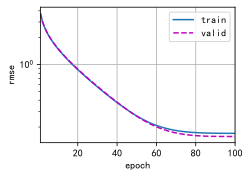

In [35]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交Kaggle预测

train log rmse 0.162676


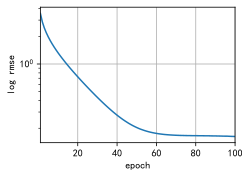

In [36]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False) # 将预测的房价结果保存下来

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)